In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torch.utils.data import Subset

from WGAN import Critic, Generator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
batch_size = 64
epochs = 6000
z_dim = 100
c_lr = 5e-5
g_lr = 5e-5
n_critic = 5
clip_threshold = 0.01
initial_linear_layer_size = [-1, 128, 4, 4]
data_path = './data'
image_save_path = './images/cifar'

os.makedirs(image_save_path, exist_ok=True)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

specific_label = 7

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_indices = [idx for idx, target in enumerate(trainset.targets) if target is specific_label]

trainloader = torch.utils.data.DataLoader(Subset(trainset, train_indices), batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
test_indices = [idx for idx, target in enumerate(testset.targets) if target is specific_label]

testloader = torch.utils.data.DataLoader(Subset(testset, test_indices), batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


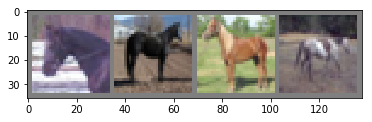

In [5]:
sample_image_batch_size = 4

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, _ = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images[:sample_image_batch_size]))

In [6]:
generator = Generator(z_dim, initial_linear_layer_size).to(device)
critic = Critic().to(device)
generator.train()
critic.train()

Critic(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
)

In [7]:
print(generator)

Generator(
  (linear): Linear(in_features=100, out_features=2048, bias=True)
  (batch_norm): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (layers): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode=nearest)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momen

In [8]:
print(critic)

Critic(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
)


In [9]:
real_label = 1.
fake_label = -1.

#D_optimizer = optim.RMSprop(params=critic.parameters(), lr=c_lr)
#G_optimizer = optim.RMSprop(params=generator.parameters(), lr=g_lr)
d_optimizer = optim.Adam(params=critic.parameters(), lr=c_lr, betas=[0, 0.9])
g_optimizer = optim.Adam(params=generator.parameters(), lr=g_lr, betas=[0, 0.9])

0 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
1 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
2 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
3 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
4 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
5 [D loss: (-0.000)(R -0.010, F 0.010)] [G loss: -0.010]
6 [D loss: (-0.000)(R -0.011, F 0.010)] [G loss: -0.010]
7 [D loss: (-0.001)(R -0.012, F 0.010)] [G loss: -0.011]
8 [D loss: (-0.002)(R -0.013, F 0.011)] [G loss: -0.011]
9 [D loss: (-0.004)(R -0.016, F 0.013)] [G loss: -0.013]
10 [D loss: (-0.005)(R -0.020, F 0.015)] [G loss: -0.016]
11 [D loss: (-0.008)(R -0.028, F 0.020)] [G loss: -0.020]
12 [D loss: (-0.010)(R -0.035, F 0.025)] [G loss: -0.026]
13 [D loss: (-0.009)(R -0.042, F 0.033)] [G loss: -0.034]
14 [D loss: (-0.018)(R -0.058, F 0.040)] [G loss: -0.042]
15 [D loss: (-0.019)(R -0.067, F 0.048)] [G loss: -0.051]
16 [D loss: (-0.008)(R -0.064, F 0.056)] [G loss: -0.055]
17 [D loss: (-0.005)(R -

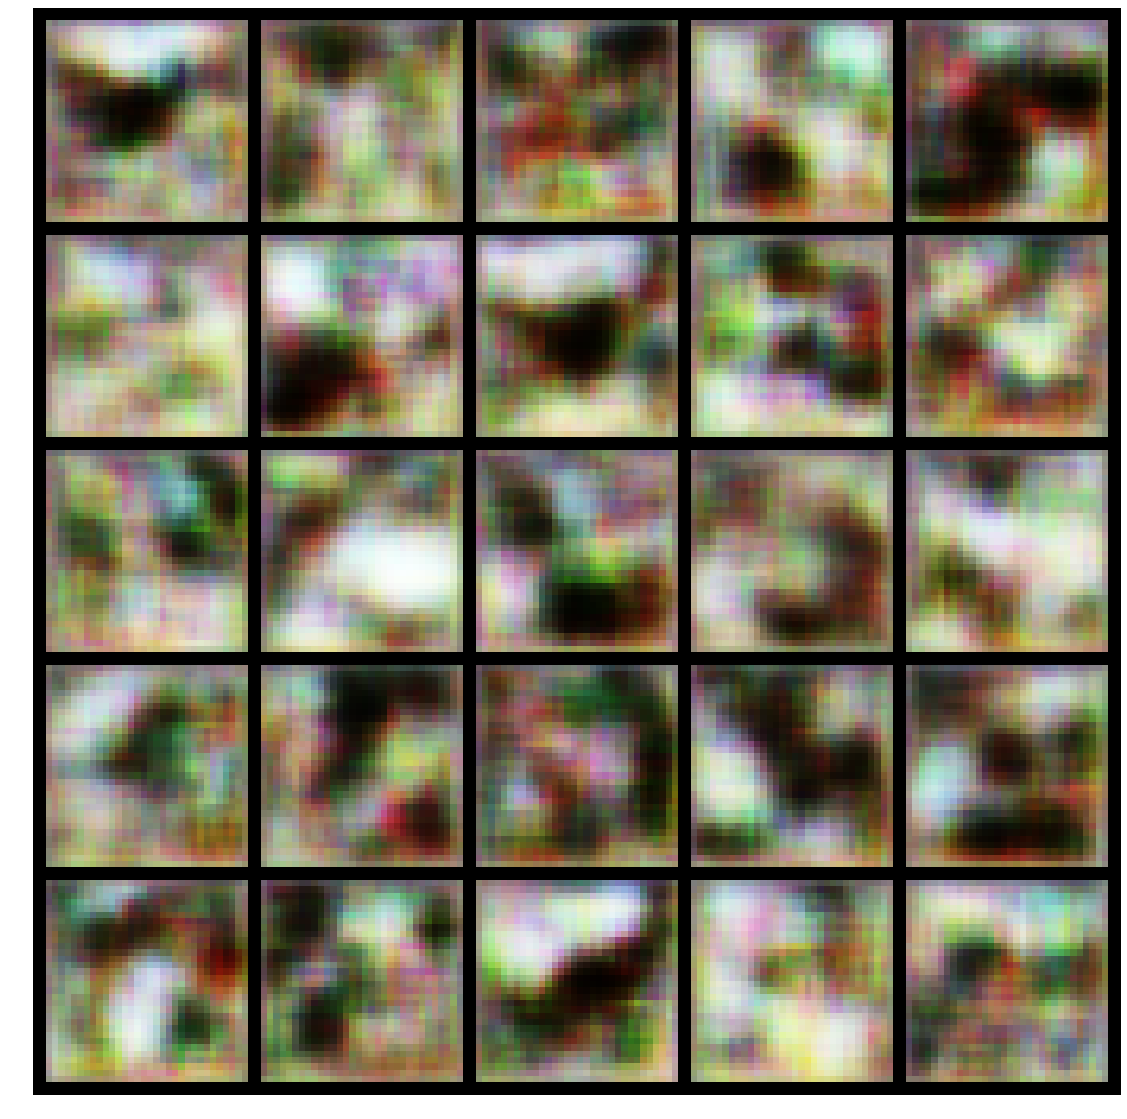

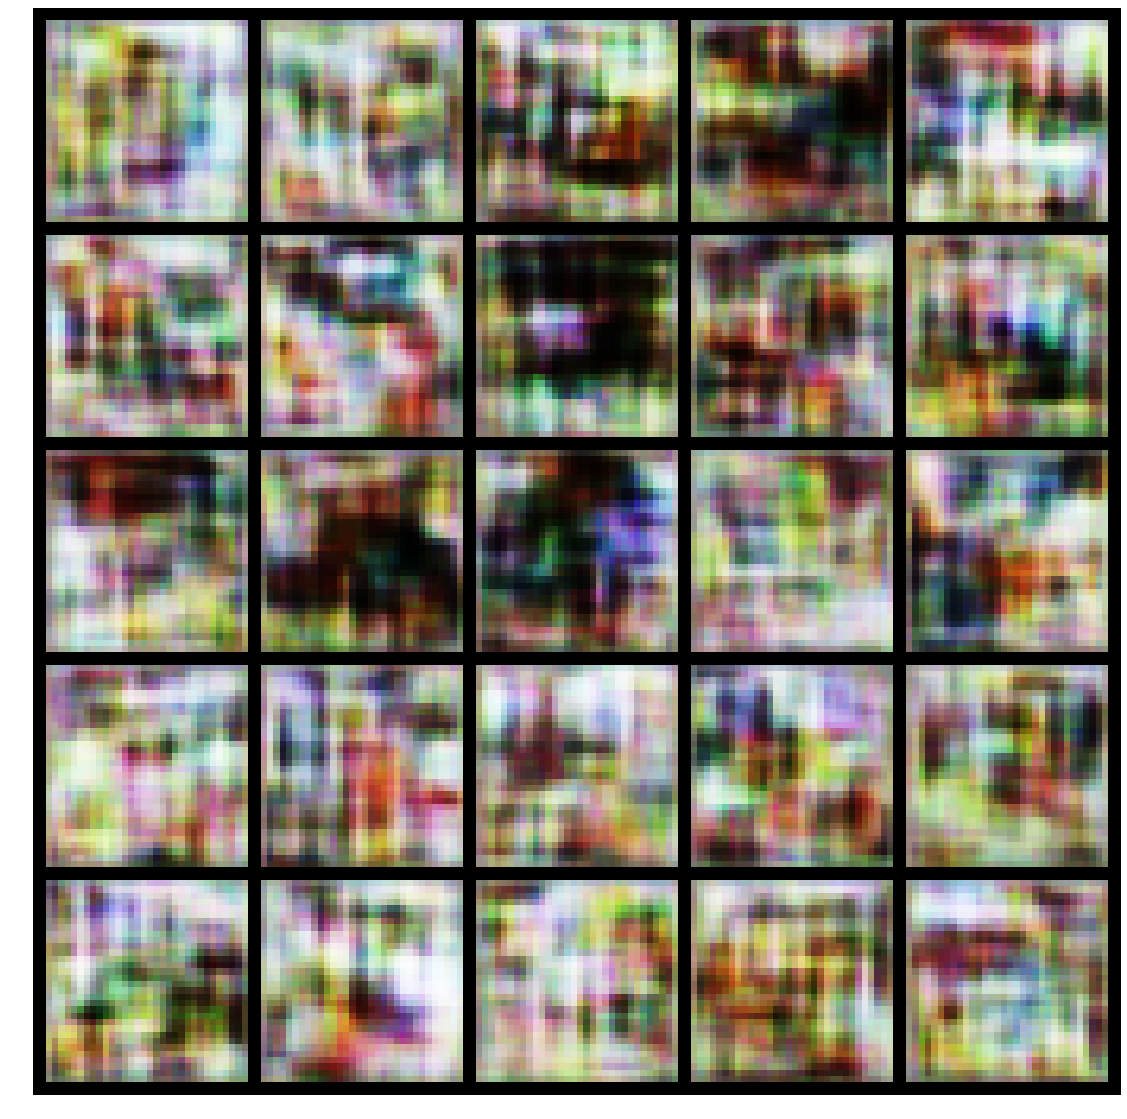

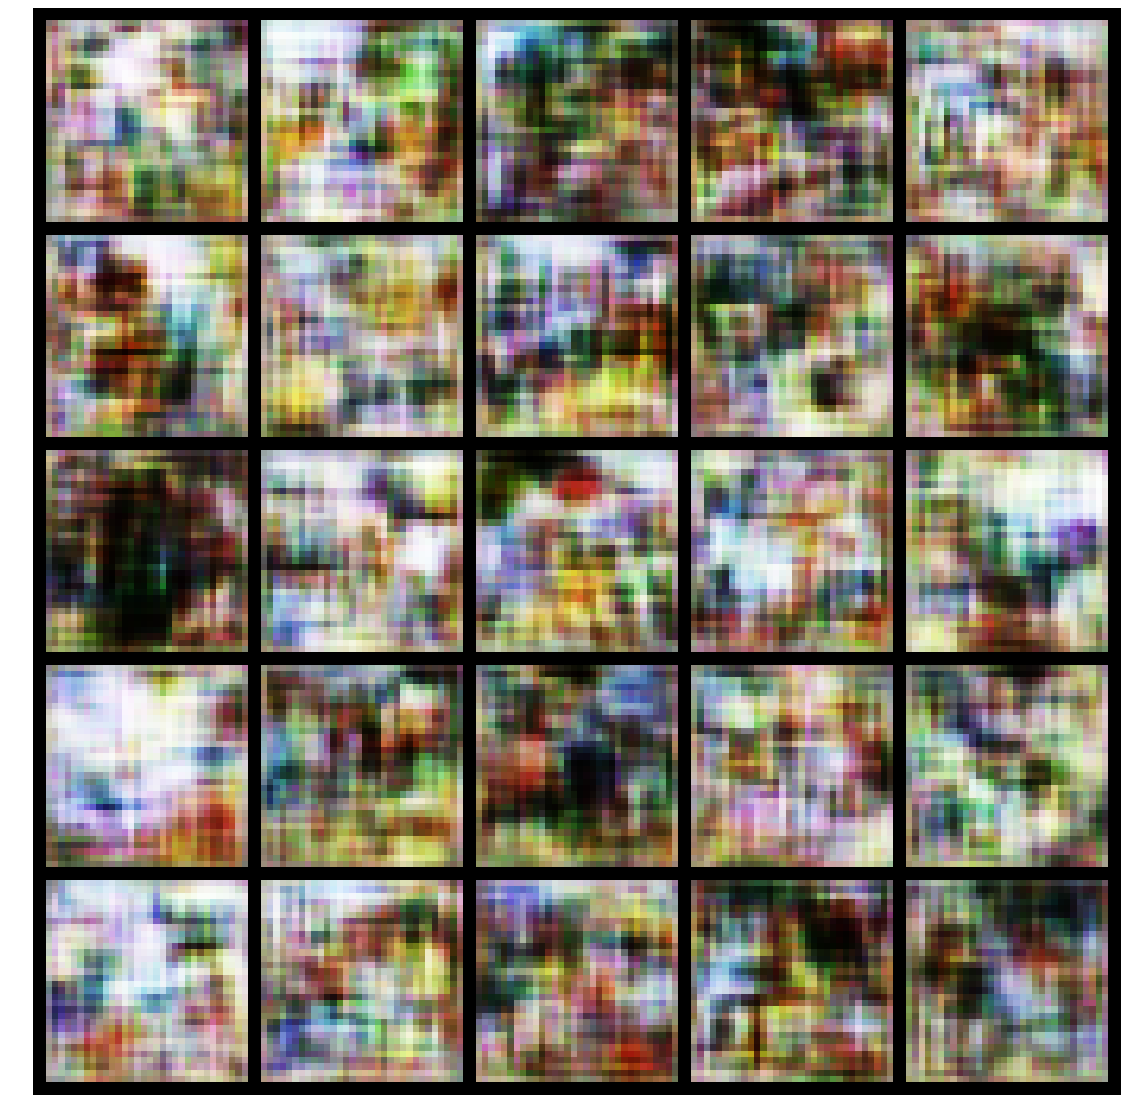

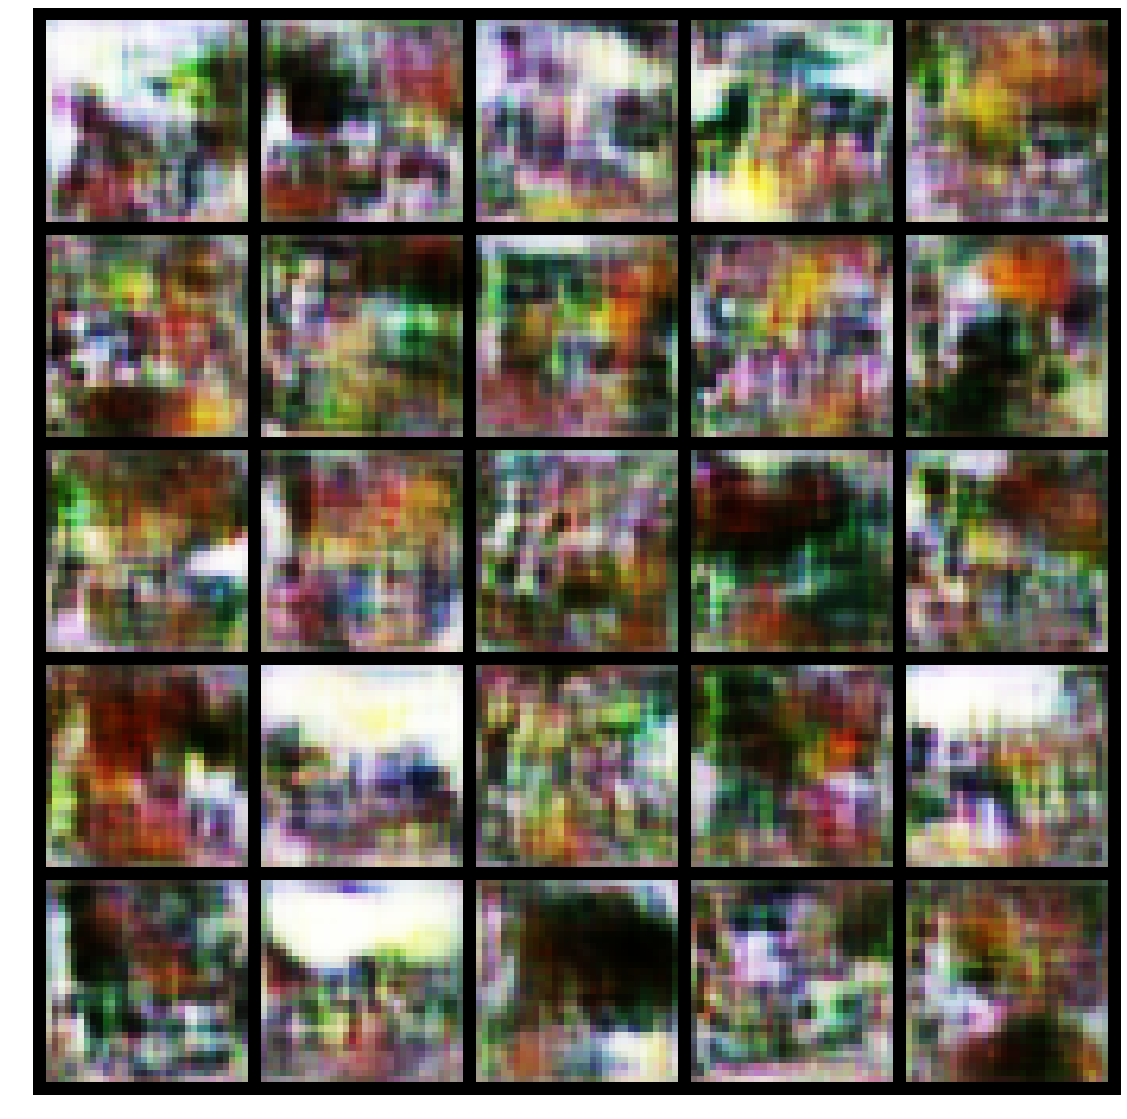

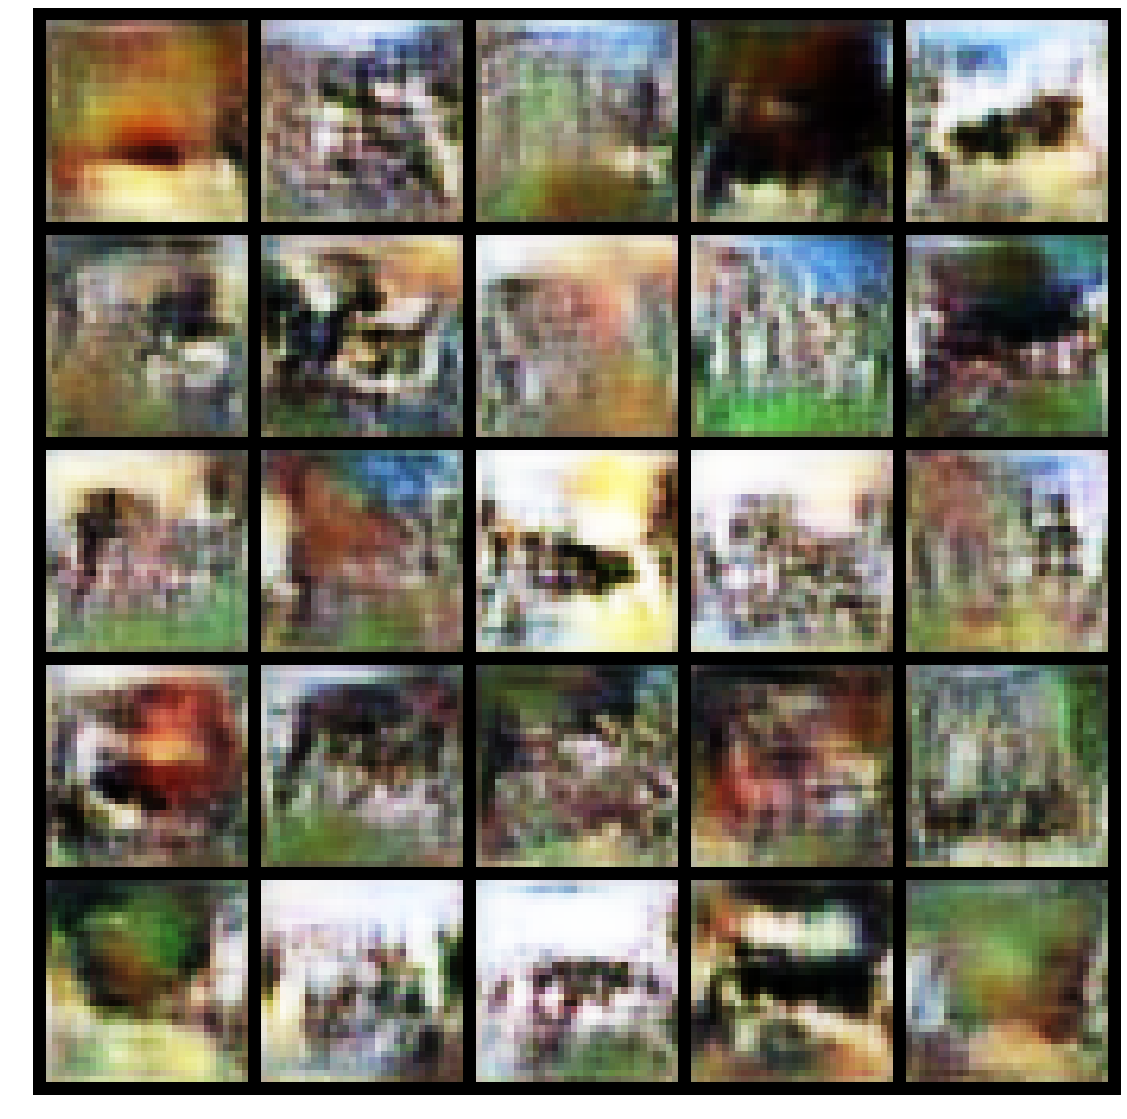

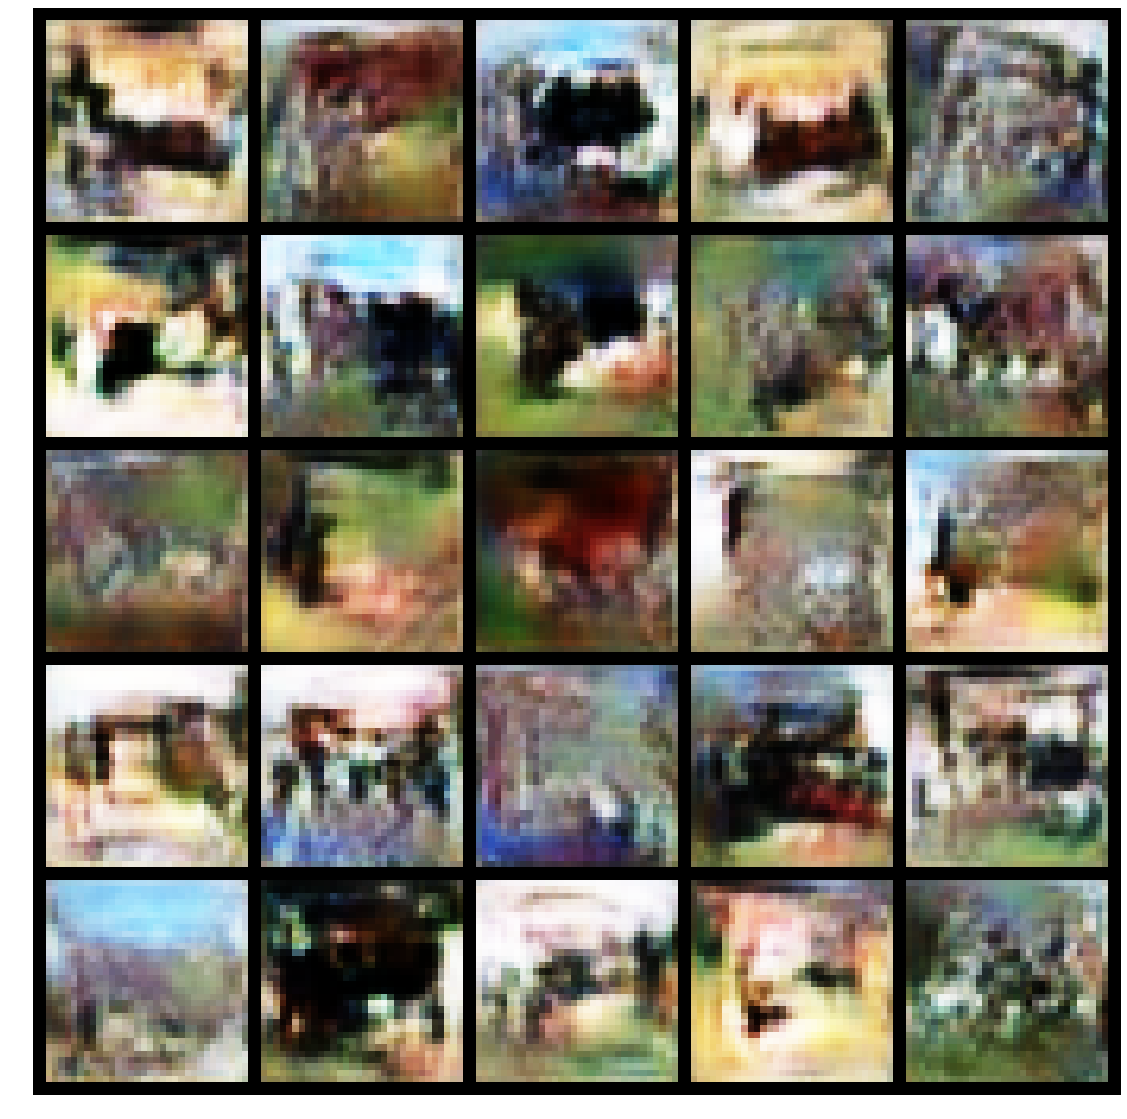

In [10]:
g_losses = []
d_losses = []
d_losses_real = []
d_losses_fake = []

for epoch in range(epochs):
    for param in critic.parameters():
        param.requires_grad = True
    for _ in range(n_critic):
        critic.zero_grad()
        
        # 진짜 데이터로 학습
        data = next(iter(trainloader))
        inputs = data[0].to(device)
        b_size = inputs.size(0)
        
        output = critic(inputs)
        d_loss_real = output.mean().view(-1)
        d_loss_real.backward(torch.cuda.FloatTensor([-1]))
        
        # 가짜 데이터로 학습
        noise = torch.randn(b_size, z_dim, device=device)
        fake = generator(noise)
        output = critic(fake)
        d_loss_fake = output.mean().view(-1)
        d_loss_fake.backward(torch.cuda.FloatTensor([1]))
        
        d_loss = -d_loss_real + d_loss_fake
        #D_loss.backward()
        d_optimizer.step()
        
        # 1-Lipshitz continuous function
        for p in critic.parameters():
            p.data.clamp_(-clip_threshold, clip_threshold)
            
    d_losses.append(d_loss.item())
    d_losses_real.append(-d_loss_real.item())
    d_losses_fake.append(d_loss_fake.item())
            
    # Generator
    for param in critic.parameters():
        param.requires_grad = False
    generator.zero_grad()
    noise = torch.randn(b_size, z_dim, device=device)
    g_output = generator(noise)
    output = critic(g_output)
    g_loss = output.mean().view(-1)
    g_loss.backward(torch.cuda.FloatTensor([-1]))
    g_optimizer.step()
        
    g_losses.append(-g_loss.item())
        
    print('%d [D loss: (%.3f)(R %.3f, F %.3f)] [G loss: %.3f]' %
            (epoch, d_loss, -d_loss_real, d_loss_fake, -g_loss))
        
    if epoch + 1 in [50, 200, 500, 1000, 3000, 6000]:
        plt.figure(figsize=(20, 20))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(fake[:25],
                                                 nrow=5,
                                                 padding=2,
                                                 normalize=True).detach().cpu(), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_path, f'epoch_{epoch + 1}.png'))


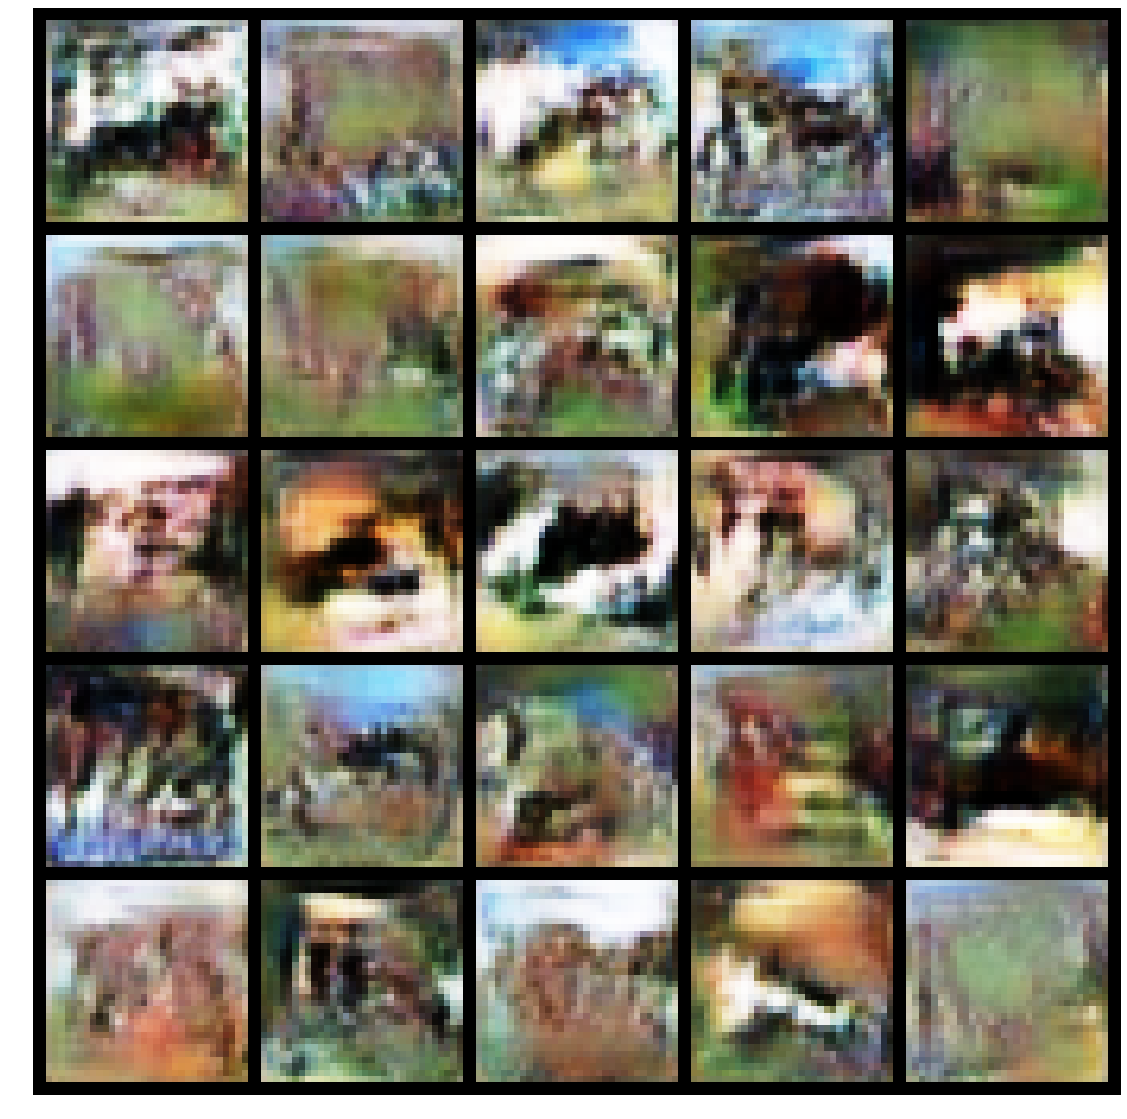

In [11]:
noise = torch.randn(25, z_dim, device=device)

gen_imgs = generator(noise).detach().cpu()

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_imgs,
                                         nrow=5,
                                         padding=2,
                                         normalize=True), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, f'gen_imgs.png'))

In [13]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in d_losses], color='black', linewidth=0.1)
plt.plot([x for x in d_losses_real], color='green', linewidth=0.1)
plt.plot([x for x in d_losses_fake], color='red', linewidth=0.1)
plt.plot([x for x in g_losses], color='orange', linewidth=0.1)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.show()

TypeError: __init__() got an unexpected keyword argument 'figsiize'